# Load checkpoints and data

In [1]:
import os.path

import pandas as pd
import numpy as np
import torch
from generative_model.bgm import BGM
from config_cade_nootbook import get_config_celeba
from preprocess.preprocess_img import make_dataloader
from attacker_cade import CADELatent
from torchvision.utils import save_image
import models.resnet as resnet
import models.vgg as vgg

torch.backends.cudnn.deterministic=True


args = get_config_celeba()
print(args)
device = torch.device('cuda')
substitute = args.substitute
epsilon = args.epsilon
type_loss = args.type_loss
num_steps = args.num_steps
step_size = args.step_size
path_ckpt_generative = args.path_ckpt_generative
path_ckpt_resnet50 = args.path_ckpt_resnet50
path_ckpt_resnet50_pgd = args.path_ckpt_resnet50_pgd
path_ckpt_vgg16 = args.path_ckpt_vgg16
path_ckpt_vgg16_pgd = args.path_ckpt_vgg16_pgd

ckpt_generative = torch.load(path_ckpt_generative, map_location=device)
ckpt_resnet50 = torch.load(path_ckpt_resnet50, map_location=device)
ckpt_resnet50_pgd = torch.load(path_ckpt_resnet50_pgd, map_location=device)
ckpt_vgg16 = torch.load(path_ckpt_vgg16, map_location=device)
ckpt_vgg16_pgd = torch.load(path_ckpt_vgg16_pgd, map_location=device)

A = torch.zeros((6, 6))
A[0, 2:6] = 1
A[1, 2:4] = 1

target_label_idx = 39  # the "young" attribute
num_classes = 2


print('Build models...')
model = BGM(latent_dim=100,
            conv_dim=32,
            image_size=64,
            enc_dist='gaussian',
            enc_arch='resnet',
            enc_fc_size=1024,
            enc_noise_dim=128,
            dec_dist='implicit',
            prior='nlrscm',
            num_label=6,
            A=A)
model.load_state_dict(ckpt_generative['model'])
model.eval()
model.to(device)

model_resnet50 = resnet.ResNet50(num_classes=num_classes).to(device)
model_resnet50.load_state_dict(ckpt_resnet50)
model_resnet50_pgd = resnet.ResNet50(num_classes=num_classes).to(device)
model_resnet50_pgd.load_state_dict(ckpt_resnet50_pgd)
model_vgg16 = vgg.VGG('VGG16', num_classes=num_classes).to(device)
model_vgg16.load_state_dict(ckpt_vgg16)
model_vgg16_pgd = vgg.VGG('VGG16', num_classes=num_classes).to(device)
model_vgg16_pgd.load_state_dict(ckpt_vgg16_pgd)

model_resnet50.eval()
model_resnet50_pgd.eval()
model_vgg16.eval()
model_vgg16_pgd.eval()

print('Model loaded')

Namespace(image_size=64, dataset='celeba', substitute='resnet50', data_dir='data/', batch_size=32, num_steps=200, epsilon=0.7, step_size=0.5, type_loss='celeba', path_ckpt_generative='ckpt/celeba/celeba_bgm.pt', path_ckpt_resnet50='ckpt/celeba/celeba_resnet50.pt', path_ckpt_resnet50_pgd='ckpt/celeba/celeba_defense_resnet50_pgd.pt', path_ckpt_vgg16='ckpt/celeba/celeba_vgg16.pt', path_ckpt_vgg16_pgd='ckpt/celeba/celeba_defense_vgg16_pgd.pt')
Build models...
2048
2048
Model loaded


In [2]:
data_loader = make_dataloader(args)
data_loader

In [3]:
for batch_id, (x, label) in enumerate(data_loader):
    if batch_id == 7: break # select batach 7
x = x.to(device)
label = label[:, target_label_idx].long().to(device)

# Attack on z_{1:5}

In [4]:
if substitute == 'resnet50':
    model_white = model_resnet50
elif substitute == 'vgg16':
    model_white = model_vgg16
model_white.eval()

attacking_nodes = [1, 2, 3, 4, 5]
scales = np.load('scales_celaba.npy')
epsilons = torch.FloatTensor(scales[attacking_nodes] * epsilon).to(device)

attacker = CADELatent(model, attacking_nodes=attacking_nodes, substitute=model_white, device=device)

print("Attacking variables: ", attacking_nodes)
print("-------------------------------------------")

Attacking variables:  [1, 2, 3, 4, 5]
-------------------------------------------


In [5]:
x_cade = attacker.attack_whitebox(x, label, lr=step_size, epochs=num_steps, type_loss=type_loss, epsilon=epsilons, causal_layer=False)

pred_resnet50 = torch.argmax(model_resnet50(x_cade), dim=1)
pred_resnet50_pgd = torch.argmax(model_resnet50_pgd(x_cade), dim=1)  # transfer to resnet50 pgd defense
pred_vgg16 = torch.argmax(model_vgg16(x_cade), dim=1)  # transfer to vgg16
pred_vgg16_pgd = torch.argmax(model_vgg16_pgd(x_cade), dim=1)  # transfer to vgg16 pgd defense

is_success_resnet50 = (torch.abs(pred_resnet50 - label) > 0).float()
is_success_resnet50_pgd = (torch.abs(pred_resnet50_pgd - label) > 0).float()
is_success_vgg16 = (torch.abs(pred_vgg16 - label) > 0).float()
is_success_vgg16_pgd = (torch.abs(pred_vgg16_pgd - label) > 0).float()

num_success_resnet50_batch_i = torch.sum(is_success_resnet50)
num_success_resnet50_pgd_batch_i = torch.sum(is_success_resnet50_pgd)
num_success_vgg16_batch_i = torch.sum(is_success_vgg16)
num_success_vgg16_pgd_batch_i = torch.sum(is_success_vgg16_pgd)

print("attacked!")
print("resnet50, asr: {}".format(num_success_resnet50_batch_i / (label.shape[0])))
print("resnet50 pgd defense, asr: {}".format(num_success_resnet50_pgd_batch_i / (label.shape[0])))
print("vgg16, asr: {}".format(num_success_vgg16_batch_i / (label.shape[0])))
print("vgg16 pgd defense, asr: {}".format(num_success_vgg16_pgd_batch_i / (label.shape[0])))
print("-------------------------------------------")

epoch: 0, loss_pred: 16.13751983642578
epoch: 1, loss_pred: 15.587202072143555
epoch: 2, loss_pred: 13.69494915008545
epoch: 3, loss_pred: 12.247740745544434
epoch: 4, loss_pred: 11.79549503326416
epoch: 5, loss_pred: 11.439720153808594
epoch: 6, loss_pred: 9.63276481628418
epoch: 7, loss_pred: 9.035812377929688
epoch: 8, loss_pred: 8.7870454788208
epoch: 9, loss_pred: 8.83574104309082
epoch: 10, loss_pred: 7.592546463012695
epoch: 11, loss_pred: 6.548985958099365
epoch: 12, loss_pred: 6.7914934158325195
epoch: 13, loss_pred: 5.757237911224365
epoch: 14, loss_pred: 5.567849636077881
epoch: 15, loss_pred: 3.7933077812194824
epoch: 16, loss_pred: 3.3903794288635254
epoch: 17, loss_pred: 4.045299053192139
epoch: 18, loss_pred: 3.111772060394287
epoch: 19, loss_pred: 3.234724998474121
epoch: 20, loss_pred: 2.611034870147705
epoch: 21, loss_pred: 2.108015775680542
epoch: 22, loss_pred: 2.2508018016815186
epoch: 23, loss_pred: 1.9066274166107178
epoch: 24, loss_pred: 3.129096746444702
epoch:

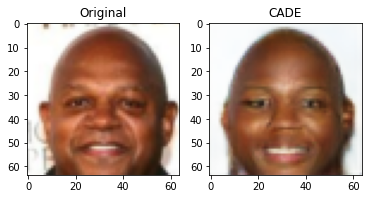

In [6]:
from torchvision.transforms import functional as F
%matplotlib inline
import matplotlib.pyplot as plt

from torchvision.utils import save_image

def denorm(x):
    out = (x + 1) / 2
    return out.clamp_(0, 1)
plt.subplot(121)
plt.title("Original")
plt.imshow(F.to_pil_image(denorm(x[1])))
plt.subplot(122)
plt.title("CADE")
plt.imshow(F.to_pil_image(denorm(x_cade[1])))